# Multivariate Time series

## Loading packages

In [1]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn import preprocessing
import seaborn as sns
tf.random.set_seed(99)


## Loading data

In [2]:
data = pd.read_csv('synthetic_data.csv')

data

,role,frequency_of_travel,primary_purpose,travel_days,travel_hours,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,...,additional_features_frequency,additional_features_seats,additional_features_cleanliness,additional_features_comfortable,additional_features_route_coverage,additional_features_updates,issues_with_quality_of_info,special_events,seasonal_changes,is_valid
0,Undergraduate student,Daily,Commute to classes,"Monday, Tuesday, Wednesday, Thursday, Friday","0900 - 1000, 1000 - 1100, 1100 - 1200, 1200 - ...",A2,Opp University Hall,Ventus,Friday,09:30:00,...,1,2,6,5,2,3,Yes,3,"No, service is consistent",True
1,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Wednesday, Thursday","0900 - 1000, 1100 - 1200, 1300 - 1400, 1500 - ...",D2,KR MRT,UTown,Thursday,09:30:00,...,1,2,6,5,4,3,No,4,"No, service is consistent",True
2,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Wednesday, Thursday","1700 - 1800, 1800 - 1900, 2100 - 2200, 2200 - ...",A2,UHC,S17,Thursday,17:50:00,...,1,4,6,5,2,6,No,3,"Yes, service improves/worsens (please specify ...",True
3,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Thursday, Friday, Saturday, Sunday","1100 - 1200, 1200 - 1300, 1800 - 1900, 2100 - ...",A1,PGP Terminal,Opp UHC,Sunday,11:30:00,...,1,2,5,6,6,3,No,3,"No, service is consistent",True
4,Undergraduate student,1 - 2 days a week,Commute to classes,"Tuesday, Thursday, Friday","0700 - 0800, 1000 - 1100, 1100 - 1200, 1200 - ...",A1,KR MRT,LT27,Friday,07:50:00,...,1,2,6,5,4,2,No,1,"Yes, service improves/worsens (please specify ...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55845,Undergraduate student,Daily,Commute to classes,"Monday, Wednesday, Friday","0900 - 1000, 1100 - 1200, 1600 - 1700",K,KR MRT,CLB,Friday,09:24:30,...,1,4,6,5,4,6,No,3,"No, service is consistent",True
55846,Visitor,Less than once a week,Travelling to food establishments,"Monday, Thursday, Friday, Saturday, Sunday","1100 - 1200, 1400 - 1500, 1500 - 1600, 1600 - ...",A1,KR MRT,CLB,Sunday,18:50:01,...,1,1,6,5,4,2,Yes,4,"Yes, service improves/worsens (please specify ...",True
55847,Undergraduate student,1 - 2 days a week,Commute to classes,"Monday, Tuesday, Wednesday, Thursday, Friday, ...","0900 - 1000, 1100 - 1200, 1200 - 1300, 1500 - ...",A1,LT13,KR MRT,Friday,11:41:45,...,1,4,6,5,6,5,No,4,"Yes, service improves/worsens (please specify ...",True
55848,Undergraduate student,1 - 2 days a week,Commute to classes,"Monday, Tuesday, Thursday, Friday","1100 - 1200, 1200 - 1300",A2,Opp YIH,S17,Tuesday,11:45:45,...,2,4,6,5,3,3,No,2,"No, service is consistent",True


## Formatting time and day of the week to represent dates

In [3]:
data['time_start'] = pd.to_datetime(data['time_start'])

def assign_date(row):
    if row['day_of_the_week'] == 'Monday':
        return '2024-11-01'  # Date for Mondays
    elif row['day_of_the_week'] == 'Tuesday':
        return '2024-11-02'  # Date for Tuesdays
    elif row['day_of_the_week'] == 'Wednesday':
        return '2024-11-03'  # Date for Wednesdays
    elif row['day_of_the_week'] == 'Thursday':
        return '2024-11-04'  # Date for Thursdays
    elif row['day_of_the_week'] == 'Friday':
        return '2024-11-05'  # Date for Fridays
    elif row['day_of_the_week'] == 'Saturday':
        return '2024-11-06'  # Date for Saturday
    else:
        return '2024-11-07' 

# Apply the function to create a new date column
data['new_date'] = data.apply(assign_date, axis=1)

# Combine the new date with the existing time
data['time_start'] = data.apply(lambda x: pd.to_datetime(f"{x['new_date']} {x['time_start'].strftime('%H:%M:%S')}"), axis=1)

# Now apply rounding to the nearest minute
data['time_start'] = data['time_start'].dt.round('1min')

data

C:\Users\enqil\AppData\Local\Temp\ipykernel_24136\3976766242.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['time_start'] = pd.to_datetime(data['time_start'])


,role,frequency_of_travel,primary_purpose,travel_days,travel_hours,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,...,additional_features_seats,additional_features_cleanliness,additional_features_comfortable,additional_features_route_coverage,additional_features_updates,issues_with_quality_of_info,special_events,seasonal_changes,is_valid,new_date
0,Undergraduate student,Daily,Commute to classes,"Monday, Tuesday, Wednesday, Thursday, Friday","0900 - 1000, 1000 - 1100, 1100 - 1200, 1200 - ...",A2,Opp University Hall,Ventus,Friday,2024-11-05 09:30:00,...,2,6,5,2,3,Yes,3,"No, service is consistent",True,2024-11-05
1,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Wednesday, Thursday","0900 - 1000, 1100 - 1200, 1300 - 1400, 1500 - ...",D2,KR MRT,UTown,Thursday,2024-11-04 09:30:00,...,2,6,5,4,3,No,4,"No, service is consistent",True,2024-11-04
2,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Wednesday, Thursday","1700 - 1800, 1800 - 1900, 2100 - 2200, 2200 - ...",A2,UHC,S17,Thursday,2024-11-04 17:50:00,...,4,6,5,2,6,No,3,"Yes, service improves/worsens (please specify ...",True,2024-11-04
3,Undergraduate student,3 - 4 days a week,Commute to classes,"Monday, Thursday, Friday, Saturday, Sunday","1100 - 1200, 1200 - 1300, 1800 - 1900, 2100 - ...",A1,PGP Terminal,Opp UHC,Sunday,2024-11-07 11:30:00,...,2,5,6,6,3,No,3,"No, service is consistent",True,2024-11-07
4,Undergraduate student,1 - 2 days a week,Commute to classes,"Tuesday, Thursday, Friday","0700 - 0800, 1000 - 1100, 1100 - 1200, 1200 - ...",A1,KR MRT,LT27,Friday,2024-11-05 07:50:00,...,2,6,5,4,2,No,1,"Yes, service improves/worsens (please specify ...",True,2024-11-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55845,Undergraduate student,Daily,Commute to classes,"Monday, Wednesday, Friday","0900 - 1000, 1100 - 1200, 1600 - 1700",K,KR MRT,CLB,Friday,2024-11-05 09:24:00,...,4,6,5,4,6,No,3,"No, service is consistent",True,2024-11-05
55846,Visitor,Less than once a week,Travelling to food establishments,"Monday, Thursday, Friday, Saturday, Sunday","1100 - 1200, 1400 - 1500, 1500 - 1600, 1600 - ...",A1,KR MRT,CLB,Sunday,2024-11-07 18:50:00,...,1,6,5,4,2,Yes,4,"Yes, service improves/worsens (please specify ...",True,2024-11-07
55847,Undergraduate student,1 - 2 days a week,Commute to classes,"Monday, Tuesday, Wednesday, Thursday, Friday, ...","0900 - 1000, 1100 - 1200, 1200 - 1300, 1500 - ...",A1,LT13,KR MRT,Friday,2024-11-05 11:42:00,...,4,6,5,6,5,No,4,"Yes, service improves/worsens (please specify ...",True,2024-11-05
55848,Undergraduate student,1 - 2 days a week,Commute to classes,"Monday, Tuesday, Thursday, Friday","1100 - 1200, 1200 - 1300",A2,Opp YIH,S17,Tuesday,2024-11-02 11:46:00,...,4,6,5,3,3,No,2,"No, service is consistent",True,2024-11-02


In [4]:

data = data.drop(columns=['role', 'frequency_of_travel','primary_purpose', 'travel_days', 'travel_hours', 'not_able_to_get_on', 'additional_features_frequency', 'additional_features_seats',
                          'additional_features_cleanliness', 'additional_features_comfortable', 'additional_features_route_coverage', 'additional_features_updates',
                          'issues_with_quality_of_info', 'special_events', 'seasonal_changes', 'new_date'])


In [5]:
data

,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,...,usage_influence_lack_of_options,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness,is_valid
0,A2,Opp University Hall,Ventus,Friday,2024-11-05 09:30:00,15 - 20 minutes,2,5,4,5,...,1,5,4,3,4,6,5,2,1,True
1,D2,KR MRT,UTown,Thursday,2024-11-04 09:30:00,10 - 15 minutes,4,3,4,3,...,3,4,5,1,4,6,5,3,2,True
2,A2,UHC,S17,Thursday,2024-11-04 17:50:00,< 5 minutes,2,4,4,3,...,3,4,5,1,2,3,5,4,6,True
3,A1,PGP Terminal,Opp UHC,Sunday,2024-11-07 11:30:00,10 - 15 minutes,4,4,4,4,...,3,5,4,3,2,6,4,5,1,True
4,A1,KR MRT,LT27,Friday,2024-11-05 07:50:00,< 5 minutes,4,3,4,4,...,2,5,4,1,3,6,4,5,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55845,K,KR MRT,CLB,Friday,2024-11-05 09:24:00,5 - 10 minutes,2,3,4,2,...,1,4,5,1,4,6,5,3,2,True
55846,A1,KR MRT,CLB,Sunday,2024-11-07 18:50:00,10 - 15 minutes,1,4,4,5,...,3,4,5,1,4,3,6,5,2,True
55847,A1,LT13,KR MRT,Friday,2024-11-05 11:42:00,5 - 10 minutes,2,4,5,3,...,4,5,3,1,4,5,3,6,2,True
55848,A2,Opp YIH,S17,Tuesday,2024-11-02 11:46:00,< 5 minutes,4,4,4,5,...,1,4,5,1,3,6,5,2,4,True


## Visualising data

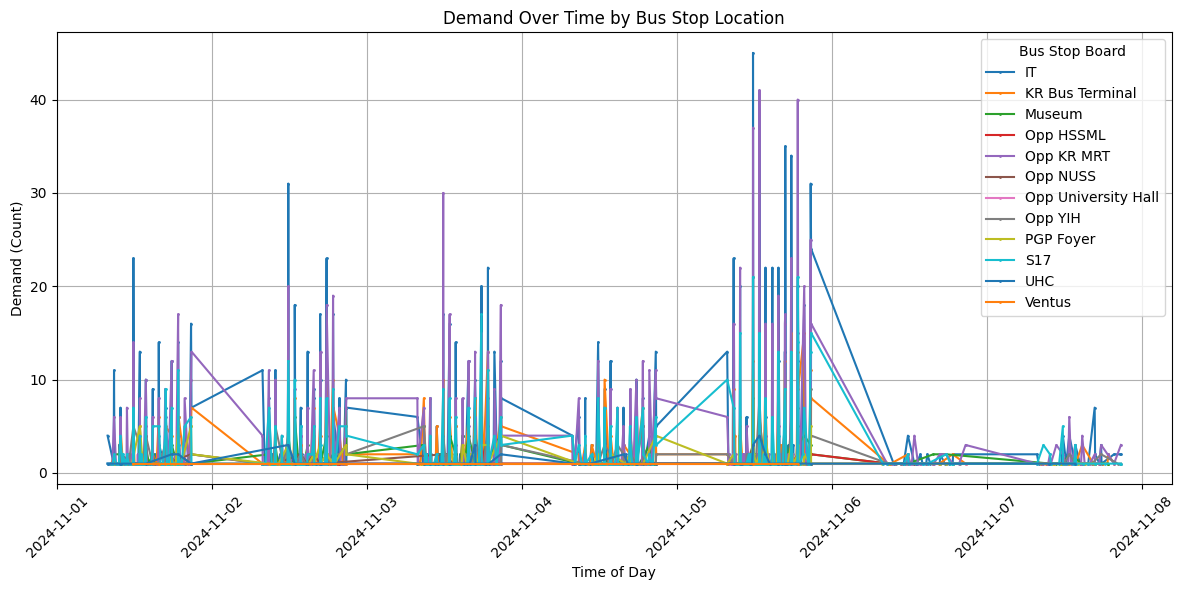

,bus_stop_board,time_start,count
0,IT,2024-11-01 07:46:00,4
1,IT,2024-11-01 08:43:00,1
2,IT,2024-11-01 08:46:00,11
3,IT,2024-11-01 08:50:00,1
4,IT,2024-11-01 08:56:00,1
...,...,...,...
2848,Ventus,2024-11-02 20:46:00,1
2849,Ventus,2024-11-03 14:32:00,1
2850,Ventus,2024-11-04 10:46:00,1
2851,Ventus,2024-11-05 11:46:00,1


In [6]:
a1 = data[(data['ISB_Service'] == 'A2')]

a1_grouped = a1.groupby(['bus_stop_board', 'time_start']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 6))
for bus_stop_board in a1_grouped['bus_stop_board'].unique():
    subset = a1_grouped[a1_grouped['bus_stop_board'] == bus_stop_board]
    plt.plot(subset['time_start'], subset['count'], label=bus_stop_board, marker='o', markersize=1)

# Configure plot labels and title
plt.title('Demand Over Time by Bus Stop Location')
plt.xlabel('Time of Day')
plt.ylabel('Demand (Count)')
plt.xticks(rotation=45)
plt.legend(title='Bus Stop Board')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

a1_grouped

In [7]:
## Grouping data

grouped_data = data.groupby(['ISB_Service', 'bus_stop_board', 'time_start']).agg(
    count=('ISB_Service', 'size'),  # Get count for each group
    frequency = ('frequency', 'mean'),
    punctuality = ('punctuality', 'mean'),
    cleanliness = ('cleanliness', 'mean'),
    safety = ('safety', 'mean'),
    coverage = ('coverage', 'mean'),
    crowdedness = ('crowdedness', 'mean'),
    usage_influence_convenience = ('usage_influence_convenience', 'mean'),
    usage_influence_cost = ('usage_influence_cost', 'mean'),
    usage_influence_lack_of_options = ('usage_influence_lack_of_options', 'mean'),
    usage_influence_availability_of_parking = ('usage_influence_availability_of_parking', 'mean'),
    usage_influence_environmental = ('usage_influence_environmental', 'mean'),
    prioritize_frequency = ('prioritize_frequency', 'mean'),
    prioritize_punctuality = ('prioritize_punctuality', 'mean'),
    prioritize_cleanliness = ('prioritize_cleanliness', 'mean'),
    prioritize_safety = ('prioritize_safety', 'mean'),
    prioritize_bus_route_coverage = ('prioritize_bus_route_coverage', 'mean'),
    prioritize_crowdedness = ('prioritize_crowdedness', 'mean')

)


# Reset the index if needed to make it easier to work with
grouped_data = grouped_data.reset_index()

# Display the grouped and aggregated data
grouped_data


,ISB_Service,bus_stop_board,time_start,count,frequency,punctuality,cleanliness,safety,coverage,crowdedness,...,usage_influence_cost,usage_influence_lack_of_options,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness
0,A1,BIZ2,2024-11-01 07:46:00,1,5.0,4.0,4.0,5.0,5.0,2.0,...,2.0,3.0,5.0,4.0,3.0,4.0,6.0,5.0,2.0,1.0
1,A1,BIZ2,2024-11-01 08:04:00,1,2.0,4.0,4.0,2.0,4.0,3.0,...,3.0,2.0,5.0,4.0,1.0,2.0,6.0,4.0,5.0,3.0
2,A1,BIZ2,2024-11-01 08:12:00,1,2.0,3.0,4.0,4.0,4.0,5.0,...,2.0,3.0,5.0,4.0,1.0,3.0,5.0,6.0,4.0,2.0
3,A1,BIZ2,2024-11-01 08:18:00,1,3.0,4.0,5.0,3.0,4.0,5.0,...,2.0,1.0,5.0,4.0,1.0,2.0,6.0,5.0,3.0,4.0
4,A1,BIZ2,2024-11-01 08:35:00,1,4.0,3.0,3.0,5.0,4.0,4.0,...,3.0,1.0,5.0,4.0,1.0,4.0,6.0,5.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19084,K,YIH,2024-11-05 18:42:00,1,4.0,4.0,5.0,3.0,3.0,2.0,...,2.0,3.0,4.0,5.0,1.0,2.0,6.0,5.0,3.0,4.0
19085,K,YIH,2024-11-05 18:49:00,1,3.0,4.0,4.0,5.0,5.0,4.0,...,3.0,1.0,5.0,4.0,1.0,4.0,6.0,3.0,5.0,2.0
19086,K,YIH,2024-11-07 08:22:00,1,4.0,4.0,3.0,5.0,5.0,4.0,...,3.0,1.0,4.0,5.0,3.0,2.0,6.0,5.0,1.0,4.0
19087,K,YIH,2024-11-07 14:35:00,1,4.0,4.0,3.0,4.0,3.0,5.0,...,3.0,2.0,5.0,4.0,1.0,2.0,6.0,4.0,5.0,3.0


,ISB_Service,bus_stop_board,time_start,count,frequency,punctuality,cleanliness,safety,coverage,crowdedness,...,usage_influence_cost,usage_influence_lack_of_options,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness
0,0,0,2024-11-01 07:46:00,1,5.0,4.0,4.0,5.0,5.0,2.0,...,2.0,3.0,5.0,4.0,3.0,4.0,6.0,5.0,2.0,1.0
1,0,0,2024-11-01 08:04:00,1,2.0,4.0,4.0,2.0,4.0,3.0,...,3.0,2.0,5.0,4.0,1.0,2.0,6.0,4.0,5.0,3.0
2,0,0,2024-11-01 08:12:00,1,2.0,3.0,4.0,4.0,4.0,5.0,...,2.0,3.0,5.0,4.0,1.0,3.0,5.0,6.0,4.0,2.0
3,0,0,2024-11-01 08:18:00,1,3.0,4.0,5.0,3.0,4.0,5.0,...,2.0,1.0,5.0,4.0,1.0,2.0,6.0,5.0,3.0,4.0
4,0,0,2024-11-01 08:35:00,1,4.0,3.0,3.0,5.0,4.0,4.0,...,3.0,1.0,5.0,4.0,1.0,4.0,6.0,5.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19084,6,23,2024-11-05 18:42:00,1,4.0,4.0,5.0,3.0,3.0,2.0,...,2.0,3.0,4.0,5.0,1.0,2.0,6.0,5.0,3.0,4.0
19085,6,23,2024-11-05 18:49:00,1,3.0,4.0,4.0,5.0,5.0,4.0,...,3.0,1.0,5.0,4.0,1.0,4.0,6.0,3.0,5.0,2.0
19086,6,23,2024-11-07 08:22:00,1,4.0,4.0,3.0,5.0,5.0,4.0,...,3.0,1.0,4.0,5.0,3.0,2.0,6.0,5.0,1.0,4.0
19087,6,23,2024-11-07 14:35:00,1,4.0,4.0,3.0,4.0,3.0,5.0,...,3.0,2.0,5.0,4.0,1.0,2.0,6.0,4.0,5.0,3.0


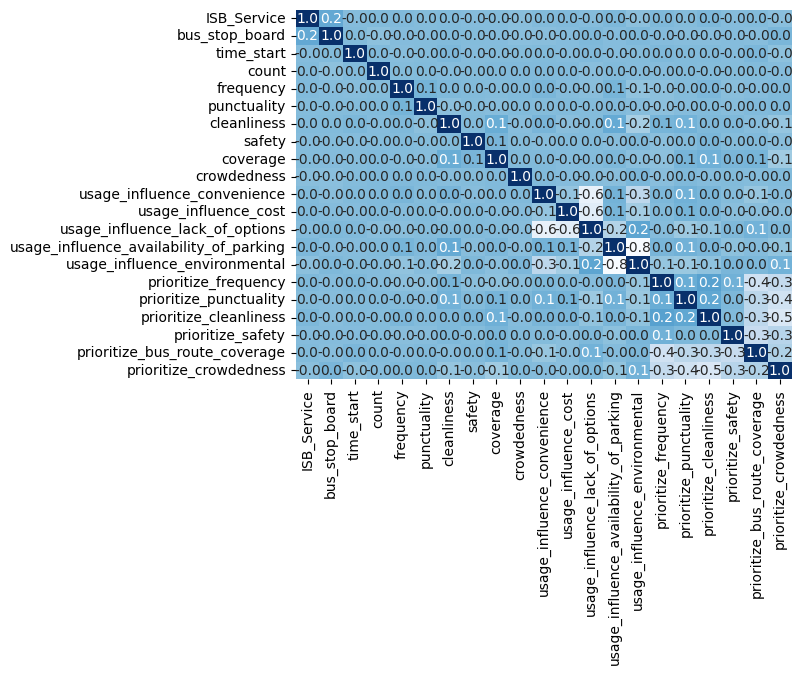

In [8]:
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
grouped_data['ISB_Service']= label_encoder.fit_transform(grouped_data['ISB_Service']) 
grouped_data['bus_stop_board']= label_encoder.fit_transform(grouped_data['bus_stop_board']) 
#grouped_data['bus_stop_alight']= label_encoder.fit_transform(grouped_data['bus_stop_alight'])  
#grouped_data['time_start']= label_encoder.fit_transform(grouped_data['time_start']) 


sns.heatmap(grouped_data.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')
grouped_data

## Time series of all features

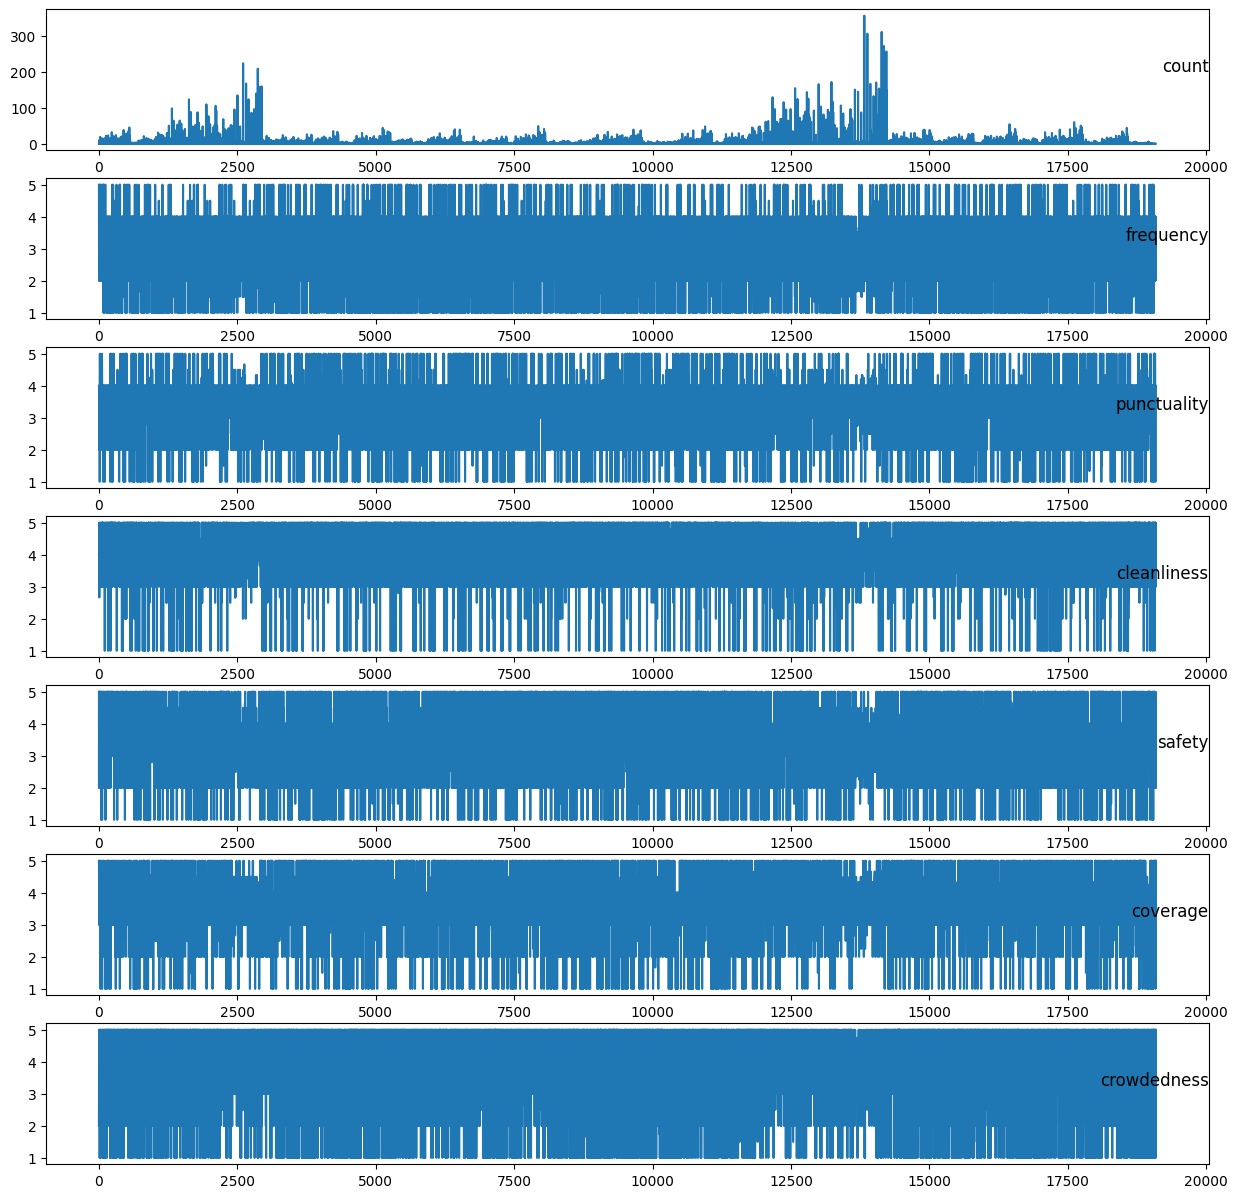

In [9]:
from matplotlib import pyplot
import matplotlib.dates as mdates

# specify columns to plot
groups = [3, 4, 5, 6, 7, 8, 9]
i = 1

values1 = grouped_data.values

# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values1[:, group])
    pyplot.title(grouped_data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()


pyplot.show()

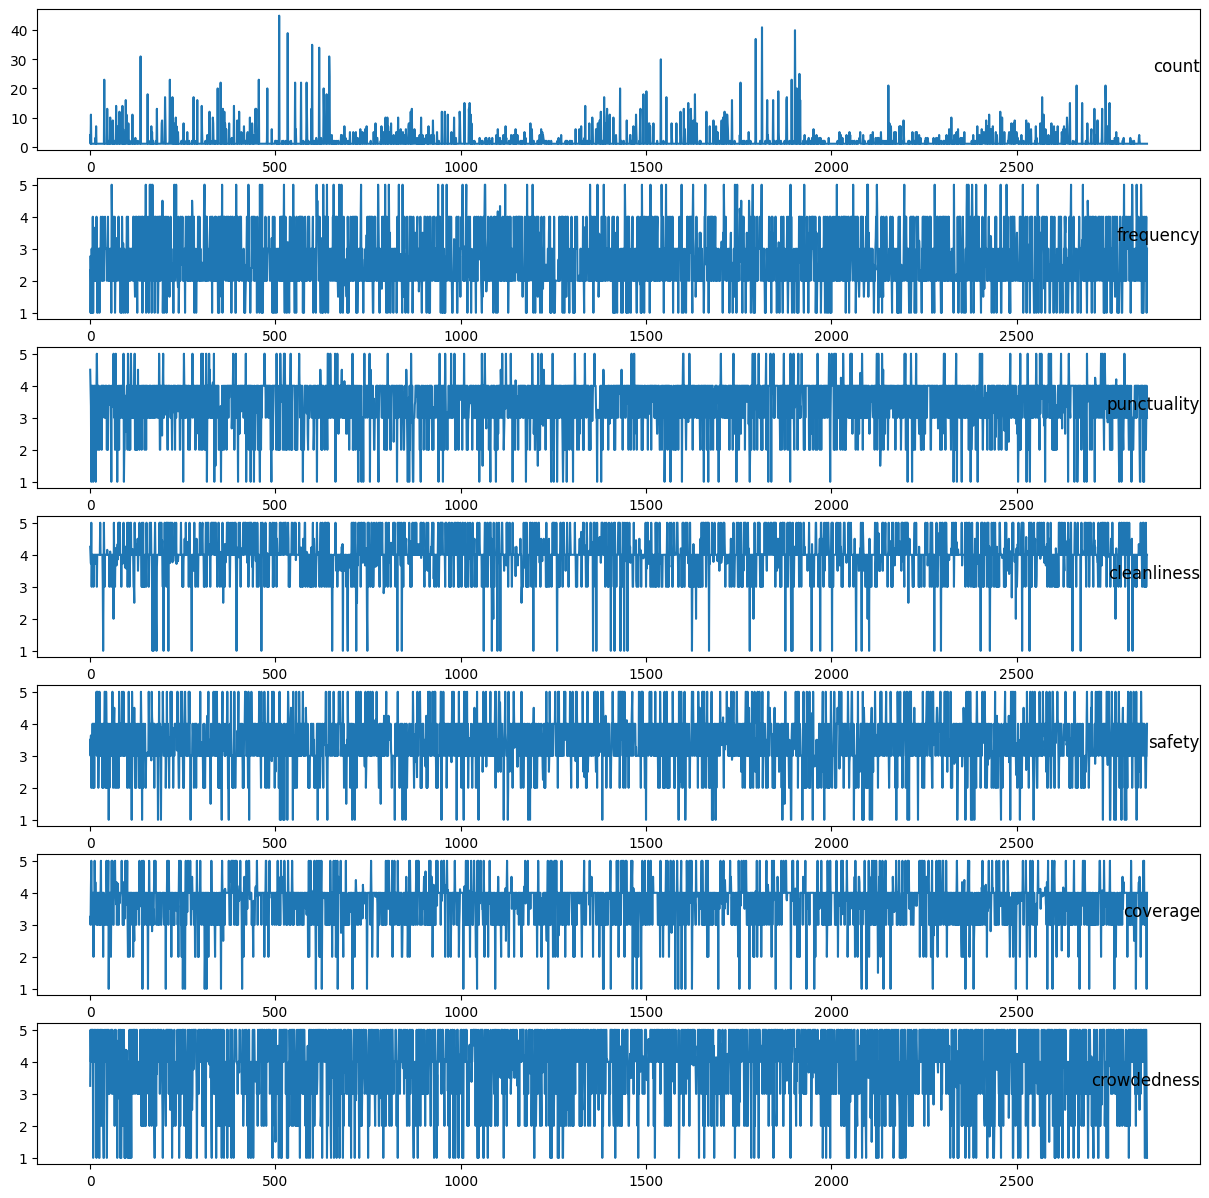

,ISB_Service,bus_stop_board,time_start,count,frequency,punctuality,cleanliness,safety,coverage,crowdedness,...,usage_influence_cost,usage_influence_lack_of_options,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness
0,0,0,2024-11-01 07:46:00,4,2.750000,4.500000,4.250000,3.500000,3.250000,3.25,...,2.0,3.250000,4.500000,4.250000,1.500000,2.500000,4.500000,4.500000,5.250000,2.750000
1,0,0,2024-11-01 08:43:00,1,1.000000,4.000000,4.000000,3.000000,3.000000,5.00,...,2.0,3.000000,5.000000,4.000000,1.000000,4.000000,6.000000,5.000000,3.000000,2.000000
2,0,0,2024-11-01 08:46:00,11,2.363636,3.363636,3.727273,3.636364,4.181818,4.00,...,2.0,2.636364,4.545455,4.454545,1.454545,2.909091,5.727273,4.727273,3.272727,2.909091
3,0,0,2024-11-01 08:50:00,1,1.000000,1.000000,5.000000,2.000000,5.000000,5.00,...,2.0,3.000000,4.000000,5.000000,1.000000,2.000000,4.000000,5.000000,3.000000,6.000000
4,0,0,2024-11-01 08:56:00,1,3.000000,4.000000,3.000000,2.000000,4.000000,5.00,...,2.0,3.000000,5.000000,4.000000,4.000000,1.000000,6.000000,5.000000,3.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2848,0,11,2024-11-02 20:46:00,1,2.000000,4.000000,3.000000,2.000000,4.000000,5.00,...,2.0,3.000000,4.000000,5.000000,1.000000,3.000000,6.000000,5.000000,4.000000,2.000000
2849,0,11,2024-11-03 14:32:00,1,3.000000,2.000000,5.000000,2.000000,4.000000,5.00,...,2.0,3.000000,4.000000,5.000000,1.000000,2.000000,6.000000,5.000000,4.000000,3.000000
2850,0,11,2024-11-04 10:46:00,1,4.000000,3.000000,3.000000,3.000000,3.000000,5.00,...,2.0,3.000000,5.000000,4.000000,3.000000,1.000000,6.000000,4.000000,5.000000,2.000000
2851,0,11,2024-11-05 11:46:00,1,1.000000,4.000000,4.000000,3.000000,1.000000,3.00,...,3.0,2.000000,5.000000,4.000000,1.000000,3.000000,6.000000,4.000000,5.000000,2.000000


In [177]:
## Grouping data

grouped_A1 = a1.groupby(['ISB_Service', 'bus_stop_board', 'time_start']).agg(
    count=('ISB_Service', 'size'),  # Get count for each group
    frequency = ('frequency', 'mean'),
    punctuality = ('punctuality', 'mean'),
    cleanliness = ('cleanliness', 'mean'),
    safety = ('safety', 'mean'),
    coverage = ('coverage', 'mean'),
    crowdedness = ('crowdedness', 'mean'),
    usage_influence_convenience = ('usage_influence_convenience', 'mean'),
    usage_influence_cost = ('usage_influence_cost', 'mean'),
    usage_influence_lack_of_options = ('usage_influence_lack_of_options', 'mean'),
    usage_influence_availability_of_parking = ('usage_influence_availability_of_parking', 'mean'),
    usage_influence_environmental = ('usage_influence_environmental', 'mean'),
    prioritize_frequency = ('prioritize_frequency', 'mean'),
    prioritize_punctuality = ('prioritize_punctuality', 'mean'),
    prioritize_cleanliness = ('prioritize_cleanliness', 'mean'),
    prioritize_safety = ('prioritize_safety', 'mean'),
    prioritize_bus_route_coverage = ('prioritize_bus_route_coverage', 'mean'),
    prioritize_crowdedness = ('prioritize_crowdedness', 'mean')

)


# Reset the index if needed to make it easier to work with
grouped_A1 = grouped_A1.reset_index()

grouped_A1['ISB_Service']= label_encoder.fit_transform(grouped_A1['ISB_Service']) 
grouped_A1['bus_stop_board']= label_encoder.fit_transform(grouped_A1['bus_stop_board']) 


from matplotlib import pyplot
import matplotlib.dates as mdates

# specify columns to plot
groups = [3, 4, 5, 6, 7, 8, 9]
i = 1

values = grouped_A1.values

# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(grouped_A1.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

grouped_A1

### Preparing training and test data + Scaling the values

In [178]:
# Shuffle the dataset
shuffled_df = grouped_A1.sample(n=len(grouped_A1))
# Reset the index of the shuffled DataFrame
shuffled_df = shuffled_df.reset_index(drop=True)

shuffled_df = shuffled_df.drop('ISB_Service', axis=1)

## Split dataset to 70% (train) and 30% (split)
train_df, test_df = shuffled_df[1:1183], shuffled_df[1183:]


train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s


shuffled_df

C:\Users\enqil\AppData\Local\Temp\ipykernel_24136\3046172488.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\enqil\AppData\Local\Temp\ipykernel_24136\3046172488.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\enqil\AppData\Local\Temp\ipykernel_24136\3046172488.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,bus_stop_board,time_start,count,frequency,punctuality,cleanliness,safety,coverage,crowdedness,usage_influence_convenience,usage_influence_cost,usage_influence_lack_of_options,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness
0,4,2024-11-04 20:08:00,1,2.00,3.000000,4.00,5.000000,4.000000,4.000000,1.000000,2.000000,3.0,4.000000,5.000000,3.000000,2.00,6.000000,5.000000,4.000000,1.0
1,4,2024-11-04 14:46:00,7,3.00,3.428571,4.00,3.857143,3.714286,4.142857,1.142857,1.857143,3.0,4.285714,4.714286,1.285714,3.00,5.428571,4.857143,3.428571,3.0
2,9,2024-11-03 16:46:00,2,2.00,4.000000,4.00,3.000000,3.500000,4.000000,1.000000,2.000000,3.0,4.000000,5.000000,1.000000,3.00,5.500000,4.500000,2.500000,4.5
3,0,2024-11-05 11:15:00,1,2.00,4.000000,5.00,3.000000,4.000000,4.000000,1.000000,2.000000,3.0,5.000000,4.000000,3.000000,1.00,5.000000,4.000000,6.000000,2.0
4,9,2024-11-03 16:19:00,1,4.00,3.000000,5.00,3.000000,4.000000,3.000000,1.000000,2.000000,3.0,5.000000,4.000000,2.000000,3.00,6.000000,5.000000,1.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2848,1,2024-11-03 13:16:00,1,2.00,4.000000,5.00,4.000000,4.000000,5.000000,1.000000,2.000000,3.0,4.000000,5.000000,2.000000,3.00,6.000000,5.000000,1.000000,4.0
2849,7,2024-11-03 12:12:00,1,2.00,3.000000,4.00,1.000000,4.000000,4.000000,1.000000,2.000000,3.0,4.000000,5.000000,1.000000,2.00,3.000000,4.000000,5.000000,6.0
2850,7,2024-11-02 09:29:00,1,1.00,4.000000,5.00,2.000000,4.000000,1.000000,3.000000,2.000000,1.0,5.000000,4.000000,3.000000,4.00,6.000000,5.000000,1.000000,2.0
2851,0,2024-11-03 14:46:00,4,2.25,3.000000,4.25,4.250000,3.500000,4.500000,1.000000,2.000000,3.0,4.250000,4.750000,1.500000,2.75,5.750000,5.250000,2.250000,3.5


#### For this case, let’s assume that given the past 7 days observation, we need to forecast the next 7 days observations.

In [179]:
n_past = 7
n_future = 7 
n_features = 20

#### Converting the series to samples

In [180]:
def split_series(series, n_past, n_future):
  
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)



In [181]:
X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))



#### Modelling

In [182]:
# E1D1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ [(None, 100),     │     48,400 │ input_layer_25[0… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 100)    │          0 │ lstm_53[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ (None, 7, 100)    │     80,400 │ repeat_vector_14… │
│                     │                   │            │ lstm_53[0][1],    │
│                     │                   │            │ lstm_53[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 7, 20)     │      2,020 │ lstm_54[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130,820 (511.02 KB)

 Trainable params: 130,820 (511.02 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
# E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ [(None, 7, 100),  │     48,400 │ input_layer_26[0… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ [(None, 100),     │     80,400 │ lstm_55[0][0]     │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_15    │ (None, 7, 100)    │          0 │ lstm_56[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 7, 100)    │     80,400 │ repeat_vector_15… │
│                     │                   │            │ lstm_55[0][1],    │
│                     │                   │            │ lstm_55[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_58 (LSTM)      │ (None, 7, 100)    │     80,400 │ lstm_57[0][0],    │
│                     │                   │            │ lstm_56[0][1],    │
│                     │                   │            │ lstm_56[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 7, 20)     │      2,020 │ lstm_58[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 291,620 (1.11 MB)

 Trainable params: 291,620 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [184]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])


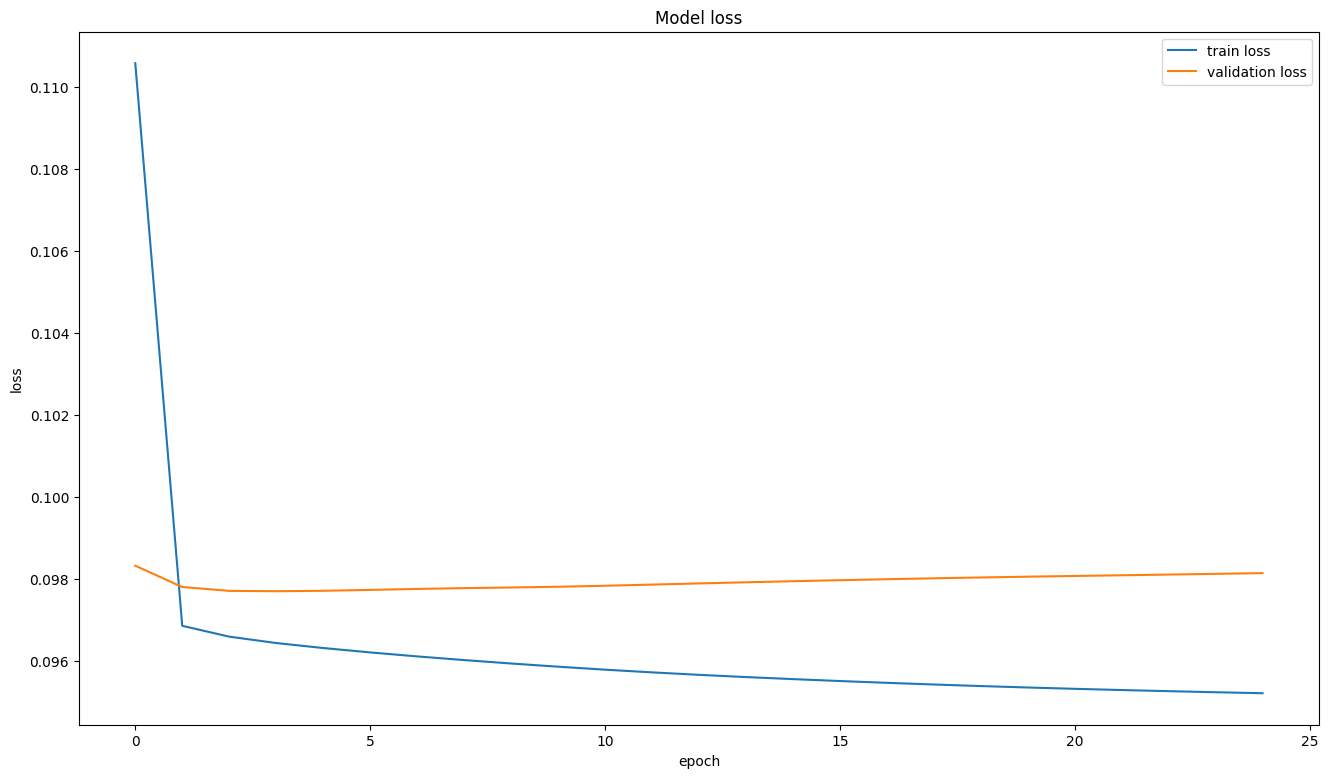

In [185]:
plt.figure(figsize=(16,9))
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [186]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

pred_e1d1

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


array([[[-0.27863482, -0.18729942, -0.9105013 , ...,  0.42332932,
          0.06550856, -0.2782556 ],
        [-0.29796892, -0.20222506, -0.907898  , ...,  0.41168895,
          0.07216343, -0.2501183 ],
        [-0.3055293 , -0.20796406, -0.9033892 , ...,  0.41112265,
          0.07199761, -0.2319008 ],
        ...,
        [-0.30161998, -0.215709  , -0.89439666, ...,  0.41759938,
          0.07024422, -0.21768136],
        [-0.29830804, -0.21922062, -0.892716  , ...,  0.42075017,
          0.06932837, -0.21542896],
        [-0.29576635, -0.22235799, -0.8924238 , ...,  0.4231377 ,
          0.06829832, -0.21435346]],

       [[-0.31007782, -0.18662675, -0.9059553 , ...,  0.41844156,
          0.04301963, -0.21576053],
        [-0.30965233, -0.18688244, -0.90393394, ...,  0.41977242,
          0.0493819 , -0.19627966],
        [-0.30828467, -0.18487903, -0.90036494, ...,  0.42616782,
          0.05034892, -0.18273783],
        ...,
        [-0.3024413 , -0.18477848, -0.8945237 , ...,  

#### Attempting to convert the predicted data back to table form to compare/fit in other questions

In [187]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

#final_pred = pd.DataFrame(pred_e1d1.reshape(-1, 1), columns=['final_pred'])

pred_e1d1

array([[[3.9675088e+00, 1.7306769e+18, 2.7899740e+00, ...,
         4.5583234e+00, 3.6637714e+00, 2.8043609e+00],
        [3.8611710e+00, 1.7306727e+18, 2.8420398e+00, ...,
         4.5292225e+00, 3.6804085e+00, 2.8747044e+00],
        [3.8195889e+00, 1.7306710e+18, 2.9322157e+00, ...,
         4.5278068e+00, 3.6799941e+00, 2.9202480e+00],
        ...,
        [3.8410900e+00, 1.7306688e+18, 3.1120667e+00, ...,
         4.5439987e+00, 3.6756105e+00, 2.9557967e+00],
        [3.8593059e+00, 1.7306677e+18, 3.1456802e+00, ...,
         4.5518751e+00, 3.6733210e+00, 2.9614277e+00],
        [3.8732851e+00, 1.7306669e+18, 3.1515238e+00, ...,
         4.5578442e+00, 3.6707458e+00, 2.9641163e+00]],

       [[3.7945721e+00, 1.7306771e+18, 2.8808937e+00, ...,
         4.5461040e+00, 3.6075492e+00, 2.9605987e+00],
        [3.7969122e+00, 1.7306769e+18, 2.9213212e+00, ...,
         4.5494308e+00, 3.6234548e+00, 3.0093007e+00],
        [3.8044345e+00, 1.7306775e+18, 2.9927013e+00, ...,
         4.565

In [130]:
# Create DataFrames for these predictions
pred_df_e1d1 = pd.DataFrame(pred_e1d1[:, :, 2], columns=[f'Feature_{i+1}' for i in range(pred_e1d1[:, :, 2].shape[1])])
pred_df_e2d2 = pd.DataFrame(pred_e2d2[:, :, 2], columns=[f'Feature_{i+1}' for i in range(pred_e2d2[:, :, 2].shape[1])])

# Displaying the first few rows of one DataFrame
pred_df_e1d1

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7
0,3.633877,2.773742,2.323824,2.135095,2.026156,1.942051,1.865955
1,3.514957,2.671356,2.261505,2.097491,2.002991,1.926100,1.852771
2,3.368842,2.713886,2.393224,2.281083,2.214303,2.151785,2.085811
3,3.517537,2.651140,2.282619,2.155674,2.086007,2.024543,1.960827
4,2.998346,2.326603,2.068492,2.012838,1.991462,1.963386,1.923163
...,...,...,...,...,...,...,...
1652,2.675972,2.149392,1.931405,1.895681,1.888208,1.873901,1.847989
1653,2.522444,2.034157,1.867609,1.882372,1.921211,1.947645,1.956520
1654,3.024114,2.250124,1.931786,1.858668,1.848413,1.847704,1.841789
1655,3.087890,2.373957,2.078755,2.025859,2.038164,2.060791,2.077197


In [127]:
import numpy as np

# Assuming pred_e1d1 is a 3D array with shape (1657, 7, 21)
# We want to extract the 'count' feature (assuming it's feature_1)

# Extract the 'count' feature (feature_1) across all time steps (7 time steps)
count_data = pred_e1d1[:, :, 2]  # Index 0 corresponds to feature_1 (count)

# Now, 'count_data' will have shape (1657, 7) representing the count feature at each time step for each sample.
print(count_data)  # Should print (1657, 7)

import pandas as pd

# Convert the count_data to a DataFrame for easier viewing
df_count = pd.DataFrame(count_data, columns=[f'count_t{i+1}' for i in range(7)])

# Display the first few rows
print(df_count.head())


[[3.6338768 2.7737424 2.323824  ... 2.026156  1.9420514 1.8659554]
 [3.5149572 2.671356  2.261505  ... 2.0029912 1.9261    1.8527708]
 [3.3688424 2.7138863 2.393224  ... 2.2143028 2.1517847 2.0858107]
 ...
 [3.0241141 2.250124  1.9317863 ... 1.8484125 1.8477044 1.8417892]
 [3.08789   2.3739574 2.0787547 ... 2.038164  2.060791  2.0771966]
 [2.815859  2.197505  1.9287    ... 1.9194613 1.9548318 1.9836948]]
   count_t1  count_t2  count_t3  count_t4  count_t5  count_t6  count_t7
0  3.633877  2.773742  2.323824  2.135095  2.026156  1.942051  1.865955
1  3.514957  2.671356  2.261505  2.097491  2.002991  1.926100  1.852771
2  3.368842  2.713886  2.393224  2.281083  2.214303  2.151785  2.085811
3  3.517537  2.651140  2.282619  2.155674  2.086007  2.024543  1.960827
4  2.998346  2.326603  2.068492  2.012838  1.991462  1.963386  1.923163


#### Evaluating the model

In [115]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

bus_stop_board
Day  1 :
MAE-E1D1 :  2.8661421058979393, MAE-E2D2 :  2.8871049282417
Day  2 :
MAE-E1D1 :  2.871041022371512, MAE-E2D2 :  2.8847300055232763
Day  3 :
MAE-E1D1 :  2.8775059228642705, MAE-E2D2 :  2.881382764500887
Day  4 :
MAE-E1D1 :  2.8791475306092504, MAE-E2D2 :  2.8845773359055826
Day  5 :
MAE-E1D1 :  2.874584373394696, MAE-E2D2 :  2.8817228236396986


time_start
Day  1 :
MAE-E1D1 :  124802330019076.33, MAE-E2D2 :  125180865296018.31
Day  2 :
MAE-E1D1 :  124626816168703.69, MAE-E2D2 :  125102640255044.12
Day  3 :
MAE-E1D1 :  124666330261776.06, MAE-E2D2 :  125144773416626.44
Day  4 :
MAE-E1D1 :  125196605207259.84, MAE-E2D2 :  125292898997586.19
Day  5 :
MAE-E1D1 :  125234155895460.23, MAE-E2D2 :  125232523318365.47


count
Day  1 :
MAE-E1D1 :  1.8641990764526337, MAE-E2D2 :  1.8627831258900422
Day  2 :
MAE-E1D1 :  1.7005547369253078, MAE-E2D2 :  1.8587823334629445
Day  3 :
MAE-E1D1 :  1.6532998333584488, MAE-E2D2 :  1.8553630407847908
Day  4 :
MAE-E1D1 :  1.67930114744

In [57]:
df2 = shuffled_df
df2_time = df2[['time_start']]
df2_train, df2_test = df2.iloc[1:1183, 1:], df2.iloc[1183:,1:]
df2_train = df2_train.drop('time_start', axis=1)
df2_test = df2_test.drop('time_start', axis=1)



,bus_stop_board,count,frequency,punctuality,cleanliness,safety,coverage,crowdedness,usage_influence_convenience,usage_influence_cost,usage_influence_lack_of_options,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness
1,4,6,3.166667,3.5,4.0,2.833333,3.833333,4.333333,1.5,2.166667,2.333333,4.833333,4.166667,1.333333,2.666667,5.666667,4.833333,2.666667,3.833333
2,1,1,3.000000,3.0,4.0,3.000000,4.000000,4.000000,3.0,2.000000,1.000000,4.000000,5.000000,1.000000,2.000000,5.000000,4.000000,6.000000,3.000000
3,4,2,4.500000,3.5,3.5,4.500000,3.500000,4.000000,1.0,2.500000,2.500000,5.000000,4.000000,1.000000,2.500000,6.000000,5.000000,2.500000,4.000000
4,9,1,3.000000,4.0,4.0,3.000000,4.000000,4.000000,1.0,2.000000,3.000000,4.000000,5.000000,1.000000,4.000000,3.000000,6.000000,5.000000,2.000000
5,7,1,2.000000,4.0,4.0,1.000000,3.000000,3.000000,1.0,2.000000,3.000000,4.000000,5.000000,3.000000,2.000000,6.000000,4.000000,5.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,4,1,3.000000,4.0,4.0,4.000000,4.000000,5.000000,1.0,2.000000,3.000000,4.000000,5.000000,1.000000,2.000000,5.000000,3.000000,4.000000,6.000000
1179,9,1,3.000000,3.0,4.0,4.000000,5.000000,5.000000,2.0,4.000000,1.000000,5.000000,3.000000,1.000000,4.000000,5.000000,6.000000,2.000000,3.000000
1180,0,1,4.000000,4.0,3.0,3.000000,4.000000,4.000000,1.0,2.000000,3.000000,4.000000,5.000000,1.000000,4.000000,6.000000,5.000000,3.000000,2.000000
1181,7,5,3.000000,4.4,4.2,3.400000,4.000000,3.200000,1.0,2.000000,3.000000,4.600000,4.400000,1.000000,3.000000,5.400000,5.200000,3.600000,2.800000


In [170]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming shuffled_df is the DataFrame
# Preprocessing: Convert timestamp to datetime and sort by timestamp
shuffled_df['time_start'] = pd.to_datetime(shuffled_df['time_start'])
shuffled_df.sort_values('time_start', inplace=True)

# Extract features and target variable
features = shuffled_df.drop(['count', 'time_start', 'bus_stop_board'], axis=1)
target = shuffled_df['count']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Function to create time series data for LSTM
def create_dataset(data, target, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

# Create time series data with time_step = 5 (use 5 past steps to predict the future)
time_step = 5
X, y = create_dataset(scaled_features, target, time_step)

# Split into train and test sets (use data from November 1 to 7 for training)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(time_step, X.shape[2])))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions (use the target scaler, not the features scaler)
target_scaler = MinMaxScaler()

# Fit the target scaler on the 'count' values (train the scaler only on the target data)
target_scaler.fit(shuffled_df[['count']])

# Now inverse transform the predicted values
predictions_rescaled = target_scaler.inverse_transform(predictions)

# Create a prediction table
prediction_table = pd.DataFrame({
    'time_start': shuffled_df['time_start'].iloc[train_size + time_step:].reset_index(drop=True),
    'predicted_count': predictions_rescaled.flatten()
})

# Display prediction table
prediction_table

Epoch 1/50


c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.1161 - val_loss: 11.6916
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2666 - val_loss: 11.6899
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2578 - val_loss: 11.6854
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2530 - val_loss: 11.6816
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2483 - val_loss: 11.6785
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2442 - val_loss: 11.6761
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2406 - val_loss: 11.6740
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2374 - val_loss: 11.6725
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2344 - val_loss: 11.6714
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2318 - val_loss: 11.6709
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2295 - val_loss: 11.6711
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2

,time_start,predicted_count
0,2024-11-05 14:47:00,80.096436
1,2024-11-05 14:47:00,64.742249
2,2024-11-05 14:48:00,100.401344
3,2024-11-05 14:49:00,39.278530
4,2024-11-05 14:50:00,161.424438
...,...,...
565,2024-11-07 20:42:00,27.508167
566,2024-11-07 20:46:00,74.395241
567,2024-11-07 20:46:00,106.882896
568,2024-11-07 20:46:00,47.978935


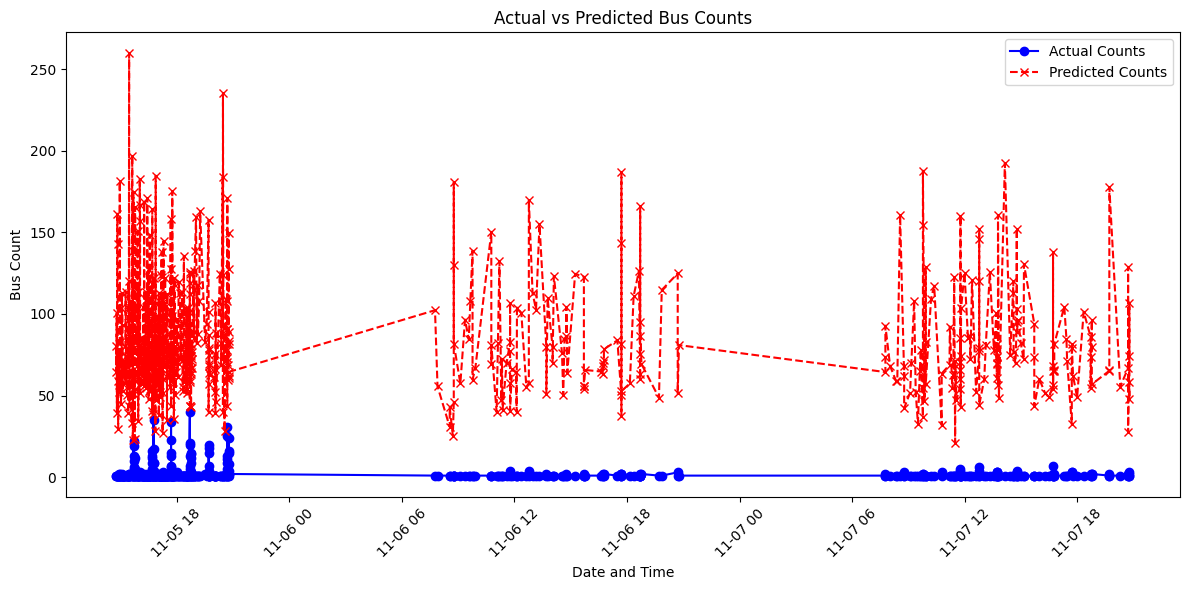

In [171]:
import matplotlib.pyplot as plt

# Extract the actual 'count' values for the test period
actual_counts = shuffled_df['count'].iloc[train_size + time_step:].reset_index(drop=True)

# Plotting the actual vs predicted counts
plt.figure(figsize=(12, 6))
plt.plot(shuffled_df['time_start'].iloc[train_size + time_step:].reset_index(drop=True), 
         actual_counts, label='Actual Counts', color='blue', linestyle='-', marker='o')
plt.plot(shuffled_df['time_start'].iloc[train_size + time_step:].reset_index(drop=True), 
         predictions_rescaled.flatten(), label='Predicted Counts', color='red', linestyle='--', marker='x')

# Adding title and labels
plt.title('Actual vs Predicted Bus Counts')
plt.xlabel('Date and Time')
plt.ylabel('Bus Count')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()




In [172]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Assuming shuffled_df contains the data from Nov 1 to Nov 7 with columns 'time_start' and 'count'

# Step 1: Feature scaling
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Exclude non-numeric columns like 'count', and 'time_start' for scaling
features = shuffled_df.drop(columns=['count', 'time_start'])  # Exclude 'time_start' and 'count' columns for features
scaled_features = scaler.fit_transform(features)

# Scaling the target variable 'count'
scaled_count = target_scaler.fit_transform(shuffled_df['count'].values.reshape(-1, 1))

# Combine the features and target for training
scaled_data = np.hstack((scaled_features, scaled_count))

# Step 2: Create sequences for LSTM
time_step = 10  # Number of time steps for LSTM

def create_sequences(data, time_step):
    X = []
    y = []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, :-1])  # All columns except the last one (target)
        y.append(data[i + time_step, -1])  # The last column (target) - predicting 'count'
    return np.array(X), np.array(y)

# Create sequences for training
X, y = create_sequences(scaled_data, time_step)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Step 3: Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))  # Output layer with one unit for the predicted count

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

# Step 4: Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_rescaled = target_scaler.inverse_transform(y_pred)  # Rescale predictions back to original values
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale actual values

# Calculate the performance metrics (e.g., Mean Squared Error)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Squared Error on the Test Data: {mse}")


Epoch 1/20


c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 15/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 16/20
72/72 ━━━━━━━━━━━━

In [173]:
# Step 5: Recursive prediction for November 8 to November 14
# Use the last sequence from the training data to predict the first day (November 8)
last_sequence = scaled_data[-time_step:].reshape((1, time_step, X_train.shape[2]))

# Initialize list to store predictions for the next 7 days (Nov 8 to Nov 14)
predicted_counts = []

# Recursive prediction for the next 7 days
for i in range(7):  # Predict the next 7 days
    # Predict the count for the next day
    next_pred = model.predict(last_sequence)
    
    # Inverse transform the prediction (only count column)
    next_pred_rescaled = target_scaler.inverse_transform(next_pred)
    
    # Append the predicted count to the list
    predicted_counts.append(next_pred_rescaled[0, 0])
    
    # Update the input sequence by appending the new prediction
    # Remove the first value and add the new predicted value to keep the input size constant
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred.reshape(1, 1, -1), axis=1)

# Step 6: Plot the result
# Generate a date range for the next 7 days starting from Nov 8
predicted_dates = pd.date_range(start=pd.to_datetime('2024-11-08'), periods=7, freq='D')

# Create a DataFrame for the predictions
future_predictions = pd.DataFrame({
    'time_start': predicted_dates,
    'predicted_count': predicted_counts
})

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(shuffled_df['time_start'], shuffled_df['count'], label='Actual Counts (Nov 1 to Nov 7)', color='blue')
plt.plot(future_predictions['time_start'], future_predictions['predicted_count'], label='Predicted Counts (Nov 8 to Nov 14)', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Bus Counts (Nov 8 to Nov 14)')
plt.xlabel('Date and Time')
plt.ylabel('Bus Count')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Display the future prediction table
future_predictions


ValueError: cannot reshape array of size 190 into shape (1,10,18)